# SHAP Model interpretation

SHAP(i.e SHapley Additive exPlanations) leverages game theory to break down a prediction to measure the impact of each feature. A prediction can be explained by assuming that each feature value of the instance is a "player" in a game where the prediction is the prize money. The Shapley value, coined by Shapley, is a method for assigning payouts to players depending on their contribution to the total prize money amount.

**If we all players(features) collaborate, how do we divide the payoff (Prediction)?**
![Data](images/prize_distribution.png)

### Compute Shapley value as the average: Average of each feature contribution over all possible feature ordering

For illustration purpose i have shown only two such series to understand the feature impact on prediction but in practice it will have 4! series for data containing 4 features = 24 possible series

![Data](images/SHAP_values.png)

**What is Shapley values**

Shapley values - Tells us how to fairly distribute the "Prize money" among the players (features).

**SHAP values show "How much has each feature value contributed to the prediction compared to the average prediction?"**

### Shap value interpretation

![Data](images/SHAP_plot.png)

# Credit Card customer churn prediction

A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction

# Get data

Load data from https://www.kaggle.com/sakshigoyal7/credit-card-customers

# Import Packages

In [1]:
## Data Analysis packages
import pandas as pd
import numpy as np

## Machine learning packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report
import xgboost
from xgboost import XGBClassifier

## Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Model Interpretation package
import shap
shap.initjs()

# Check package version
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"shap Version: {shap.__version__}")
print(f"Xgbbost Version: {xgboost.__version__}")

Pandas Version: 1.1.4
Numpy Version: 1.19.4
scikit-learn Version: 0.23.2
shap Version: 0.37.0
Xgbbost Version: 1.3.0


# Load data

In [2]:
# Data Files
data_file      = '../data/credit_card_customer_churn/BankChurners.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 10127 samples with 21 features.


# Quick data analysis

In [3]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
data['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

### Correlation Analysis

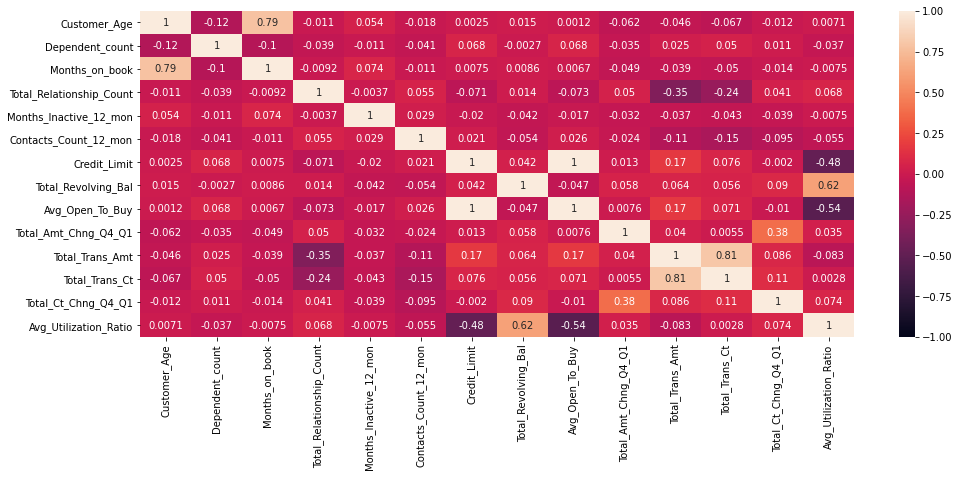

In [5]:
num_cols =['Customer_Age', 'Dependent_count', 'Months_on_book',
           'Total_Relationship_Count', 'Months_Inactive_12_mon',
           'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
           'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']

# Increase the size of the heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot=True)

## Prepare data for model training

In [6]:
# Exclude some features from the feature list for model training
exclude_feature = ['CLIENTNUM', 'Avg_Open_To_Buy', 'Attrition_Flag']
# Define Target columns
target = data['Attrition_Flag'].map({"Existing Customer": 0 , "Attrited Customer": 1})

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])

# Xgboost model Training

In [7]:
# Model Training
xgb_clf = XGBClassifier(max_depth = 3, objective='binary:logistic', eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# Check training and validation metrics
train_prediction = xgb_clf.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, train_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("=================================")
print(f"Training AUC:{roc_auc}")

val_prediction = xgb_clf.predict_proba(X_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, val_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print(f"Validation AUC:{roc_auc}")
print("=================================")

Training AUC:0.9988347678418306
Validation AUC:0.9944069374738433


## Feature Importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

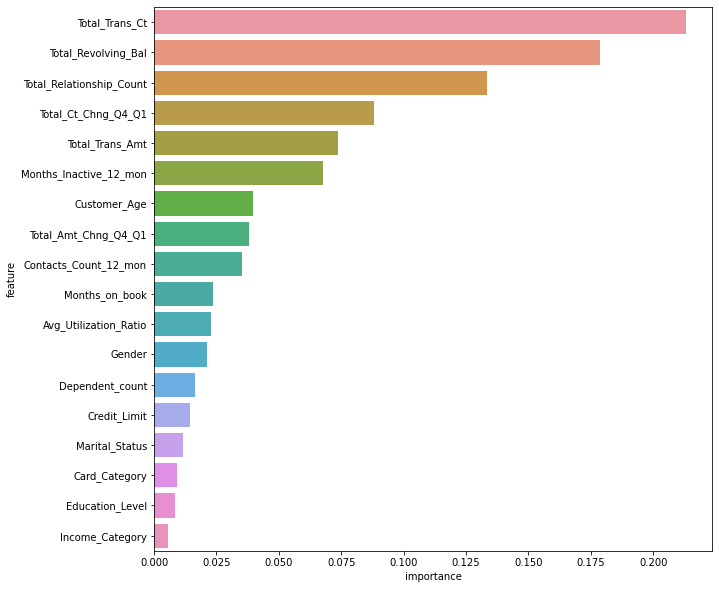

In [8]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns
feature_importance_df["importance"] = xgb_clf.feature_importances_

feature_importance_df  = feature_importance_df.sort_values('importance', ascending=False).reset_index()
plt.figure(figsize = (10, 10))
sns.barplot(x ='importance', y ='feature', data= feature_importance_df[:20])

# Model Output Interpretation

## SHAP : GLOBAL EXPLANATIONS
The SHAP library also provides with easy ways to aggregate and plot the Shapely values for a set of points( in our case the validation set) to have a global explanation for the model.

### SHAP Summary Plot : Feature Impact 
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

In [17]:
# Initialize SHAP Tree explainer
explainer = shap.TreeExplainer(xgb_clf, model_output='margin')
shap_values = explainer.shap_values(X_valid)

# Baseline value
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: -2.1674695014953613


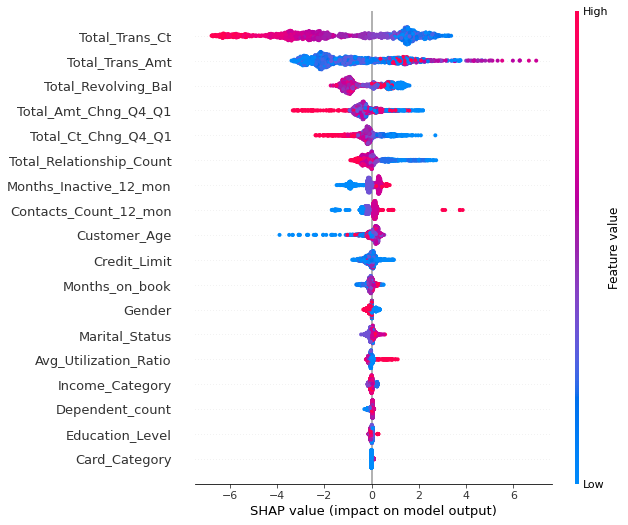

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_valid)

#### Interpreatation of SHAP Output

This plot is made of many dots. Each dot has three characteristics:

1) Vertical location shows what feature it is depicting

2) Color shows whether that feature was high (RED Color) or low (BLUE Color) for any row of the dataset

3) Horizontal location of dots shows whether the effect of that value caused a higher or lower prediction. Negative shapley value will reduce the prediction probability and Positive shapley will increase prediction probability.

**Total_Trans_ct**: Higher the value, less imapct on customer churn. High value will reduce the probability of churn.

**Months_Inactive_12_mon**:  Higher the value, more imapct on customer churn. High value will increase the probability of churn.

**Contacts_Count_12_mon**:  Higher the value, more imapct on customer churn. High will increase the probability of churn.

**Customer_Age**:  Lower the value, less imapct on customer churn. Low value will reduce the probability of churn.

**Card_Category**:  It has very less impact on churn.

This is very informative graph and provide details about how prediction will be impacted due to different values(High, low). Normal Feature importance provided by different classifier (like Xgboost in our case) will not provide detail around in which direction prediction will go based on feature value

## Decision plot

Decision plots offer a detailed view of a model’s inner workings; that is, they show how models make decisions. 
 
There are several use cases for a decision plot. 

    1) Show a large number of feature effects clearly.
    2) Visualize multioutput predictions.
    3) Display the cumulative effect of interactions.
    4) Explore feature effects for a range of feature values.
    5) Identify outliers.
    6) Identify typical prediction paths.
    7) Compare and contrast predictions for several models.

### Example 1

Actutal Outcome is 1
Predicted Outcome is 1


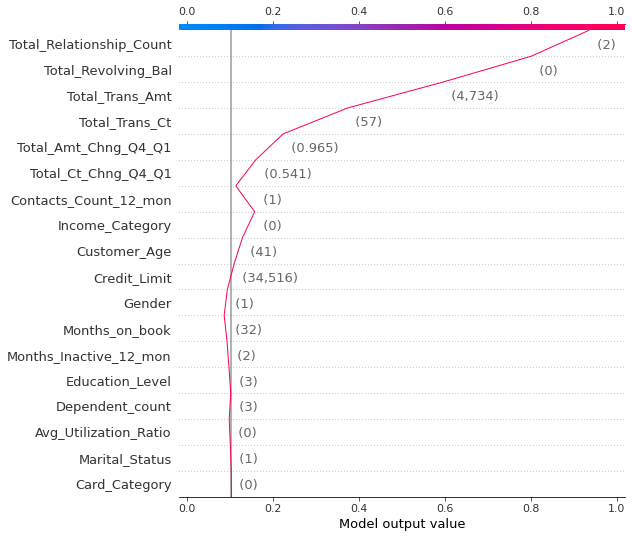

In [19]:
row = 6
pred = xgb_clf.predict_proba(X_valid.iloc[row].values.reshape(1, -1))
print(f"Actutal Outcome is {y_valid.iloc[row]}")
print(f"Predicted Outcome is {np.argmax(pred)}")
      
shap.decision_plot(base_value = expected_value, 
                   shap_values=shap_values[row], 
                   features = X_valid.iloc[row], 
                   feature_names=X_valid.columns.tolist(),
                   link='logit')

#### Interpretation
The decision plot’s straight vertical line marks the model’s base value. The colored line is the prediction. Feature values are printed next to the prediction line for reference. Starting at the bottom of the plot, the prediction line shows how the SHAP values (i.e., the feature effects) accumulate from the base value to arrive at the model’s final score at the top of the plot. (Roughly speaking, this is similar to a statistical linear model where the sum of effects, plus an intercept, equals the prediction.) Decision plots are literal representation of SHAP values, making them easy to interpret.

In [20]:
shap.force_plot(expected_value,
                shap_values[row], 
                X_valid.iloc[row], 
                link='logit', matplotlib=False)

#### Interpretation 
Red arrows represent feature effects (SHAP values) that drives the prediction value higher while blue arrows are those effects that drive the prediction value lower. Each arrow’s size represents the magnitude of the corresponding feature’s effect. The “base value” (see the grey print towards the upper-left of the image) marks the model’s average prediction over the training set. The “output value” is the model’s prediction: probability 0.94. The feature values for the largest effects are printed at the bottom of the plot. Overall, the force plot provides an effective summary for this prediction.

### Example 2

Actutal Outcome is 0
Predicted Outcome is 0


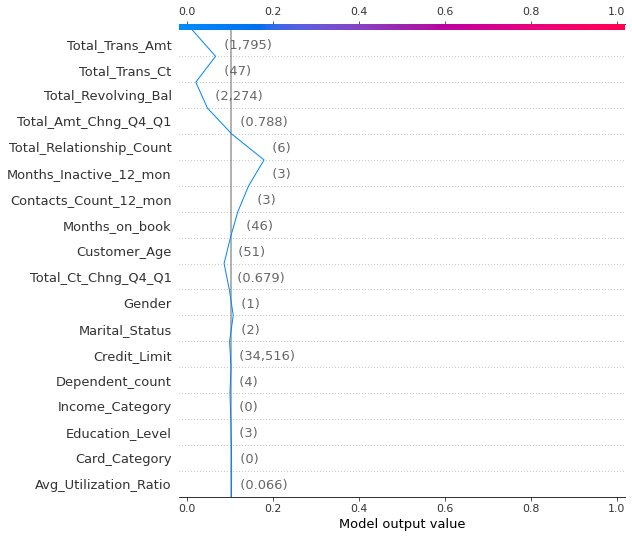

In [22]:
row = 5
pred = xgb_clf.predict_proba(X_valid.iloc[row].values.reshape(1,-1))
print(f"Actutal Outcome is {y_valid.iloc[row]}")
print(f"Predicted Outcome is {np.argmax(pred)}")

shap.decision_plot(base_value = expected_value, 
                   shap_values=shap_values[row], 
                   features = X_valid.iloc[row], 
                   feature_names=X_valid.columns.tolist(),
                   link='logit')

#### Interpretation
The decision plot’s straight vertical line marks the model’s base value. The colored line is the prediction. Feature values are printed next to the prediction line for reference. Starting at the bottom of the plot, the prediction line shows how the SHAP values (i.e., the feature effects) accumulate from the base value to arrive at the model’s final score at the top of the plot. (Roughly speaking, this is similar to a statistical linear model where the sum of effects, plus an intercept, equals the prediction.) Decision plots are literal representation of SHAP values, making them easy to interpret.

In [23]:
shap.force_plot(expected_value,
                shap_values[row], 
                X_valid.iloc[row], 
                link='logit', matplotlib=False)

#### Interpretation 
Red arrows represent feature effects (SHAP values) that drives the prediction value higher while blue arrows are those effects that drive the prediction value lower. Each arrow’s size represents the magnitude of the corresponding feature’s effect. The “base value” (see the grey print towards the upper-left of the image) marks the model’s average prediction over the training set. The “output value” is the model’s prediction: probability 0.01. The feature values for the largest effects are printed at the bottom of the plot. Overall, the force plot provides an effective summary for this prediction.

## Decision Plot for multiple samples

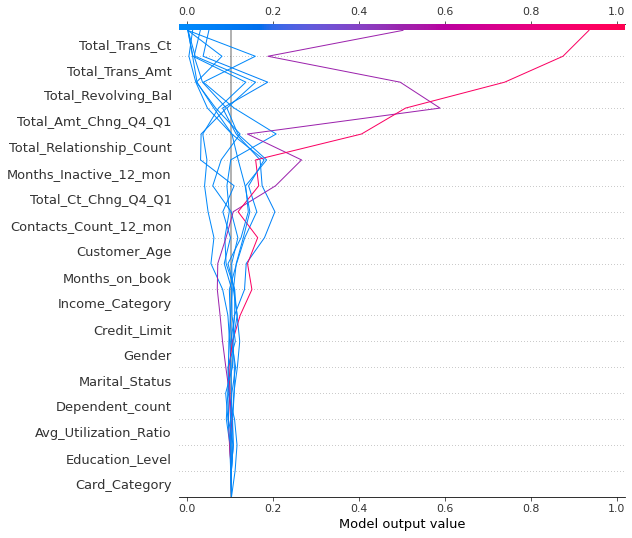

In [24]:
select_row = range(10)
pred = xgb_clf.predict_proba(X_valid.iloc[select_row])

shap.decision_plot(base_value = expected_value, 
                   shap_values=shap_values[select_row], 
                   features = X_valid.iloc[select_row], 
                   feature_names=X_valid.columns.tolist(),
                   link='logit')

## Identify typical prediction paths

A decision plot can expose a model's typical prediction paths. Here, we plot all of the predictions in the probability interval [0.95, 1.0] to see what high-scoring predictions have in common. SHAP use **'hclust'** feature ordering to group similar prediction paths.

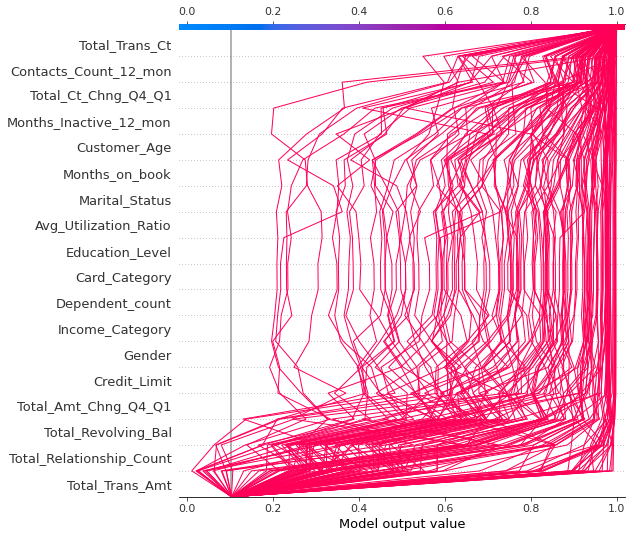

In [25]:
y_pred = xgb_clf.predict_proba(X_valid)[:, 1]  # Get predictions on the probability scale.
T = X_valid[y_pred >= 0.95]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)
shap.decision_plot(expected_value, sh, T, feature_order='hclust', link='logit')

## SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

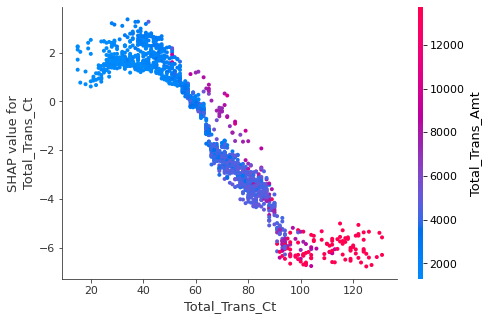

In [27]:
for name in ['Total_Trans_Ct']:
    shap.dependence_plot(name, shap_values, X_valid, display_features=None)

### Interpretation
1) Each dot represents a row of the data. 

2) The horizontal location is the actual value from the dataset, and the vertical location shows what having that value impacted prediction.

3) The  Vertical dispersion at a single value of **Total_Trans_Ct** represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot above represents the change in customer churn probability as **Total_Trans_Ct** changes.

As the **Total_Trans_Ct** increases the probability of customer churing will decrease but once it reach 90 then there is a slow decrease in probability score.

As the **Total_Trans_Amt** increase the probability of customer churing will decrease but once it reach in 2000-4000 ranges then there is a slow decrease in prediction.

### Advantages
1) The difference between the prediction and the average prediction is fairly distributed among the feature values of the instance. This property distinguishes the Shapley value from other methods such as LIME. 

2) The Shapley value might be the only method to deliver a full explanation. In situations where the law requires explainability -- like EU's "right to explanations" -- the Shapley value might be the only legally compliant method, because it is based on a solid theory and distributes the effects fairly. 

3) The Shapley value allows contrastive explanations. Instead of comparing a prediction to the average prediction of the entire dataset, you could compare it to a subset or even to a single data point. The other methods like LIME doesn't provide this functionality.

### Disadvantage
1) The Shapley value requires a lot of computing time.

2) The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training.

The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

3) The Shapley value returns a simple value per feature, but no prediction model like LIME. 

This means it cannot be used to make statements about changes in prediction for changes in the input, such as: "If I were to earn €300 more a year, my credit score would increase by 5 points."

## References

https://christophm.github.io/interpretable-ml-book/

https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba

https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b

https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html

https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d